## EDA

In [1]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns',None)
pd.set_option('display.max_rows',None)
from imblearn.over_sampling import SMOTENC
import seaborn as sns
import matplotlib.pyplot as plt
import streamlit as str
import warnings
warnings.filterwarnings('ignore')
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

***Create Dataset with dataset shape***

In [2]:
ai = pd.read_csv('../data/AI_DATASET.csv')
ai.head(1)

,job_title,salary_usd,experience_level,employment_type,company_location,company_size,remote_ratio,required_skills,education_required,years_experience,posting_date,application_deadline,job_description_length,company_name,industry,benefits_score
0,Data Scientist,219728,EX,PT,Sweden,M,0,"Python, Computer Vision, R, Docker",Associate,13,23-09-2024,31-10-2024,1132,TechCorp Inc,Transportation,6.6


In [3]:
ai.shape

(15000, 16)

In [4]:
ai.columns

Index(['job_title', 'salary_usd', 'experience_level', 'employment_type',
       'company_location', 'company_size', 'remote_ratio', 'required_skills',
       'education_required', 'years_experience', 'posting_date',
       'application_deadline', 'job_description_length', 'company_name',
       'industry', 'benefits_score'],
      dtype='object')

***Handling Missing Data***

In [5]:
ai.isna().sum()

job_title                 0
salary_usd                0
experience_level          0
employment_type           0
company_location          0
company_size              0
remote_ratio              0
required_skills           0
education_required        0
years_experience          0
posting_date              0
application_deadline      0
job_description_length    0
company_name              0
industry                  0
benefits_score            0
dtype: int64

In [6]:
ai.select_dtypes(include=[np.number,"object", "category"]).columns.tolist()

['job_title',
 'salary_usd',
 'experience_level',
 'employment_type',
 'company_location',
 'company_size',
 'remote_ratio',
 'required_skills',
 'education_required',
 'years_experience',
 'posting_date',
 'application_deadline',
 'job_description_length',
 'company_name',
 'industry',
 'benefits_score']

***Replace nan values in dataset***

In [7]:
ai['job_title']=ai['job_title'].str.strip().replace("", np.nan).astype(object)

***Find unique data in dataset***

In [8]:
ai['company_size'].unique()

array(['M', 'L', 'S'], dtype=object)

***Correcting Inaccuracies***

In [9]:
ai_dataset=ai.replace({
    'experience_level': {'EN': 'Entry-Level', 'EX': 'Executive', 'MI': 'Mid-Level', 'SE': 'Senior-Level'},
    'employment_type': {'PT': 'Part-Time', 'FT': 'Full-Time', 'CT': 'Contract', 'FL': 'Freelance'},
    'company_size': {'M': 'Medium', 'L': 'Large', 'S': 'Small'}
})

***Display formatted version only when printing or exporting***

In [10]:
ai_dataset['salary_display'] = ai_dataset['salary_usd'].apply(lambda x: f"${x:,.0f}")

***Export clean dataset***

In [11]:
ai_dataset.to_csv('ai_jobs_cleaned.csv', index=False)

***Identify potential categorical outliers (rare categories or typos)***

In [12]:
categorical_cols  = ai_dataset.select_dtypes(include= "object").columns
categorical_cols 

Index(['job_title', 'experience_level', 'employment_type', 'company_location',
       'company_size', 'required_skills', 'education_required', 'posting_date',
       'application_deadline', 'company_name', 'industry', 'salary_display'],
      dtype='object')

In [13]:
for col in categorical_cols:
    print(f"\n----{col}----")
    value_counts=ai_dataset[col].value_counts(normalize=True)*100
    rare_values=value_counts[value_counts<1]

    print("Unique categories:", len(value_counts))
    print("Rare categories (<1% of data):")
    print(rare_values if not rare_values.empty else "None found ✅")


----job_title----
Unique categories: 20
Rare categories (<1% of data):
None found ✅

----experience_level----
Unique categories: 4
Rare categories (<1% of data):
None found ✅

----employment_type----
Unique categories: 4
Rare categories (<1% of data):
None found ✅

----company_location----
Unique categories: 20
Rare categories (<1% of data):
None found ✅

----company_size----
Unique categories: 3
Rare categories (<1% of data):
None found ✅

----required_skills----
Unique categories: 13651
Rare categories (<1% of data):
required_skills
Python, TensorFlow, Tableau                                                 0.060000
Python, TensorFlow, Data Visualization                                      0.053333
Python, TensorFlow, PyTorch                                                 0.053333
Python, Git, TensorFlow                                                     0.046667
Python, NLP, TensorFlow                                                     0.046667
Hadoop, Python, TensorFlow       

## Feature engineering

***Encode***

***
1. 'FT': 'Full-Time',
2. 'PT': 'Part-Time',
3. 'CT': 'Contract',
4. 'FL': 'Freelance'
***

In [14]:
ai_dataset['employment_type']=ai_dataset['employment_type'].apply(lambda x: 1 if x=='Full-Time' 
                                    else 2 if x=="Part-Time" 
                                    else 3 if x=="Contract" else 4)

In [15]:
ai_dataset['employment_type'].unique()

array([2, 3, 4, 1])

***
1. 'EN': 'Entry Level'
2. 'EX': 'Director-level/ Expert Level',
3. 'MI': 'Mid-Level',
4. 'SE': 'Senior Level',
***

In [16]:
ai_dataset['experience_level']=ai_dataset['experience_level'].apply(lambda x: 1 if x=='Entry-Level' 
                                    else 2 if x=="Executive" 
                                    else 3 if x=="Mid-Level" 
                                    else 4 if x == 'Senior-Level'
                                    else np.nan)

***
0. 'Associate', 
1. 'Bachelor',
2. 'Master',
3. 'PhD', 
***

In [17]:
ai_dataset['education_required']=ai_dataset['education_required'].apply(lambda x: 1 if x=='Bachelor' 
                                    else 2 if x=="Master" 
                                    else 3 if x=="PhD" 
                                    else 0 if x == 'Associate'
                                    else np.nan)

***Convert strings to datetime format***

In [18]:
ai_dataset['posting_date'] = pd.to_datetime(ai_dataset['posting_date'], format='%d-%m-%Y')
ai_dataset['application_deadline'] = pd.to_datetime(ai_dataset['application_deadline'], format='%d-%m-%Y')

***Extract month and year into new columns***

In [19]:
ai_dataset['posting_month']=ai_dataset['posting_date'].dt.month
ai_dataset['posting_year']=ai_dataset['posting_date'].dt.year

In [20]:
ai_dataset['application_deadline_month']=ai_dataset['application_deadline'].dt.month
ai_dataset['application_deadline_year']=ai_dataset['application_deadline'].dt.year

In [21]:
ai_dataset['posting_month_name']=ai_dataset['posting_date'].dt.month_name()

## Statistical analysis and feature selection

***High corr***

In [22]:
ai_corr=ai_dataset.corr(numeric_only=True)
ai_corr

,salary_usd,experience_level,employment_type,remote_ratio,education_required,years_experience,job_description_length,benefits_score,posting_month,posting_year,application_deadline_month,application_deadline_year
salary_usd,1.000000,0.123284,0.007372,0.003495,-0.014004,0.744043,-0.012644,-0.001873,-0.007323,0.010354,0.001099,0.003224
experience_level,0.123284,1.000000,-0.000935,0.008820,-0.010550,0.147020,0.000359,0.000602,0.024492,-0.016347,0.027289,-0.015308
employment_type,0.007372,-0.000935,1.000000,0.009634,0.009458,0.008927,-0.011037,0.015012,-0.002631,-0.007007,0.006749,-0.010938
remote_ratio,0.003495,0.008820,0.009634,1.000000,-0.012486,0.003607,0.006687,-0.000117,-0.005474,0.006804,0.011193,-0.005644
education_required,-0.014004,-0.010550,0.009458,-0.012486,1.000000,-0.011829,0.001462,0.014257,-0.002219,0.005119,-0.000971,0.005171
years_experience,0.744043,0.147020,0.008927,0.003607,-0.011829,1.000000,-0.016349,0.002875,-0.002318,0.005390,0.008796,-0.003342
job_description_length,-0.012644,0.000359,-0.011037,0.006687,0.001462,-0.016349,1.000000,-0.002889,0.007368,0.011439,0.001379,0.015297
benefits_score,-0.001873,0.000602,0.015012,-0.000117,0.014257,0.002875,-0.002889,1.000000,-0.002369,-0.002633,0.002104,-0.005522
posting_month,-0.007323,0.024492,-0.002631,-0.005474,-0.002219,-0.002318,0.007368,-0.002369,1.000000,-0.499252,0.502803,-0.127311
posting_year,0.010354,-0.016347,-0.007007,0.006804,0.005119,0.005390,0.011439,-0.002633,-0.499252,1.000000,-0.348379,0.802736


In [23]:
corr_features=set()
for i in range(len(ai_corr.columns)):
    for j in range(i):
        if abs(ai_corr.iloc[i,j]) > 0.6:
            column_name1=ai_corr.columns[i]
            column_name2=ai_corr.columns[j]
            corr_features.add(column_name1)
            corr_features.add(column_name2)
            print(f"i is column_name1 {i}: {column_name1} and j is column_name2 {j}: {column_name2}")

i is column_name1 5: years_experience and j is column_name2 0: salary_usd
i is column_name1 11: application_deadline_year and j is column_name2 9: posting_year


In [24]:
list(corr_features)

['posting_year', 'application_deadline_year', 'years_experience', 'salary_usd']

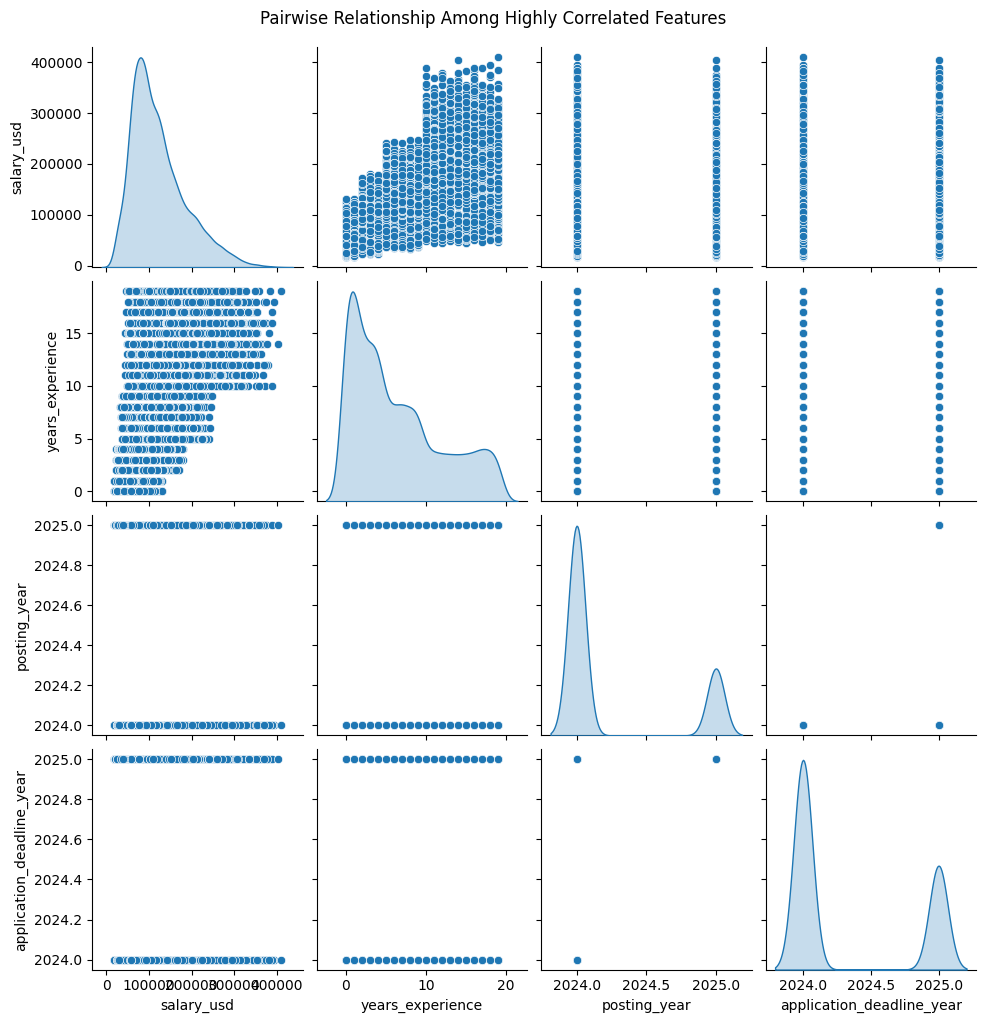

In [25]:
high_corr_features = ['salary_usd', 'years_experience', 'posting_year', 'application_deadline_year']

sns.pairplot(ai_dataset[high_corr_features], diag_kind="kde")
plt.suptitle("Pairwise Relationship Among Highly Correlated Features", y=1.02)
plt.show()

In [26]:
ai_dataset.head(1)

,job_title,salary_usd,experience_level,employment_type,company_location,company_size,remote_ratio,required_skills,education_required,years_experience,posting_date,application_deadline,job_description_length,company_name,industry,benefits_score,salary_display,posting_month,posting_year,application_deadline_month,application_deadline_year,posting_month_name
0,Data Scientist,219728,2,2,Sweden,Medium,0,"Python, Computer Vision, R, Docker",0,13,2024-09-23,2024-10-31,1132,TechCorp Inc,Transportation,6.6,"$219,728",9,2024,10,2024,September


In [27]:
ai_corr.replace({
    "education_required": {1: 'Bachelor', 2: "Master", 3: "PhD", 0: 'Associate'},
    "experience_level": {1: 'Entry-Level', 2: "Executive", 3: "Mid-Level", 4: "Senior-Level"},
    "employment_type": {1: 'Full-Time', 2: "Part-Time", 3: "Contract", 4: "Freelance"}  
})

,salary_usd,experience_level,employment_type,remote_ratio,education_required,years_experience,job_description_length,benefits_score,posting_month,posting_year,application_deadline_month,application_deadline_year
salary_usd,1.000000,0.123284,0.007372,0.003495,-0.014004,0.744043,-0.012644,-0.001873,-0.007323,0.010354,0.001099,0.003224
experience_level,0.123284,Entry-Level,-0.000935,0.008820,-0.01055,0.147020,0.000359,0.000602,0.024492,-0.016347,0.027289,-0.015308
employment_type,0.007372,-0.000935,Full-Time,0.009634,0.009458,0.008927,-0.011037,0.015012,-0.002631,-0.007007,0.006749,-0.010938
remote_ratio,0.003495,0.00882,0.009634,1.000000,-0.012486,0.003607,0.006687,-0.000117,-0.005474,0.006804,0.011193,-0.005644
education_required,-0.014004,-0.01055,0.009458,-0.012486,Bachelor,-0.011829,0.001462,0.014257,-0.002219,0.005119,-0.000971,0.005171
years_experience,0.744043,0.14702,0.008927,0.003607,-0.011829,1.000000,-0.016349,0.002875,-0.002318,0.005390,0.008796,-0.003342
job_description_length,-0.012644,0.000359,-0.011037,0.006687,0.001462,-0.016349,1.000000,-0.002889,0.007368,0.011439,0.001379,0.015297
benefits_score,-0.001873,0.000602,0.015012,-0.000117,0.014257,0.002875,-0.002889,1.000000,-0.002369,-0.002633,0.002104,-0.005522
posting_month,-0.007323,0.024492,-0.002631,-0.005474,-0.002219,-0.002318,0.007368,-0.002369,1.000000,-0.499252,0.502803,-0.127311
posting_year,0.010354,-0.016347,-0.007007,0.006804,0.005119,0.005390,0.011439,-0.002633,-0.499252,1.000000,-0.348379,0.802736


In [28]:
ai_dataset.replace({
    "education_required": {1: 'Bachelor', 2: "Master", 3: "PhD", 0: 'Associate'},
    "experience_level": {1: 'Entry-Level', 2: "Executive", 3: "Mid-Level", 4: "Senior-Level"},
    "employment_type": {1: 'Full-Time', 2: "Part-Time", 3: "Contract", 4: "Freelance"}  
}).head(1)

,job_title,salary_usd,experience_level,employment_type,company_location,company_size,remote_ratio,required_skills,education_required,years_experience,posting_date,application_deadline,job_description_length,company_name,industry,benefits_score,salary_display,posting_month,posting_year,application_deadline_month,application_deadline_year,posting_month_name
0,Data Scientist,219728,Executive,Part-Time,Sweden,Medium,0,"Python, Computer Vision, R, Docker",Associate,13,2024-09-23,2024-10-31,1132,TechCorp Inc,Transportation,6.6,"$219,728",9,2024,10,2024,September


In [29]:
ai_dataset.head()

,job_title,salary_usd,experience_level,employment_type,company_location,company_size,remote_ratio,required_skills,education_required,years_experience,posting_date,application_deadline,job_description_length,company_name,industry,benefits_score,salary_display,posting_month,posting_year,application_deadline_month,application_deadline_year,posting_month_name
0,Data Scientist,219728,2,2,Sweden,Medium,0,"Python, Computer Vision, R, Docker",0,13,2024-09-23,2024-10-31,1132,TechCorp Inc,Transportation,6.6,"$219,728",9,2024,10,2024,September
1,Head of AI,230237,2,2,Japan,Large,50,"Kubernetes, MLOps, Tableau, Python",1,10,2024-07-26,2024-09-12,2299,Cloud AI Solutions,Transportation,8.5,"$230,237",7,2024,9,2024,July
2,Data Engineer,128890,2,3,Germany,Small,100,"Spark, Scala, Hadoop, PyTorch, GCP",1,12,2025-01-19,2025-03-28,1329,Quantum Computing Inc,Automotive,5.5,"$128,890",1,2025,3,2025,January
3,Computer Vision Engineer,96349,3,4,Finland,Large,50,"MLOps, Linux, Tableau, Python",3,2,2024-07-20,2024-09-06,1132,Cognitive Computing,Automotive,6.8,"$96,349",7,2024,9,2024,July
4,Robotics Engineer,63065,1,1,France,Small,100,"R, Scala, SQL, GCP, Python",0,0,2025-03-16,2025-05-09,2011,Advanced Robotics,Finance,9.3,"$63,065",3,2025,5,2025,March


In [30]:
cols=ai_dataset.select_dtypes(include=['float64', 'int64']).columns

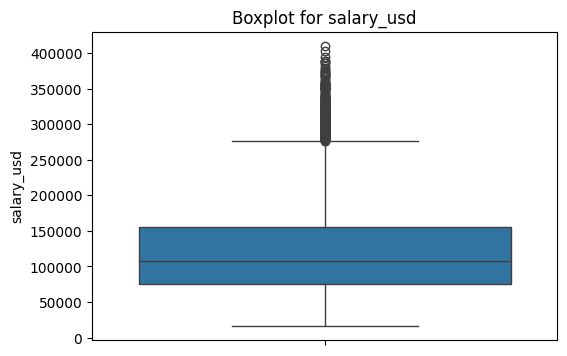

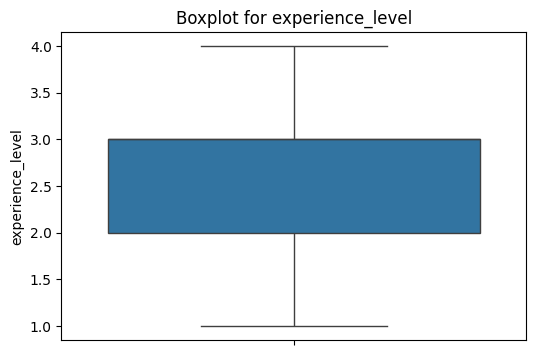

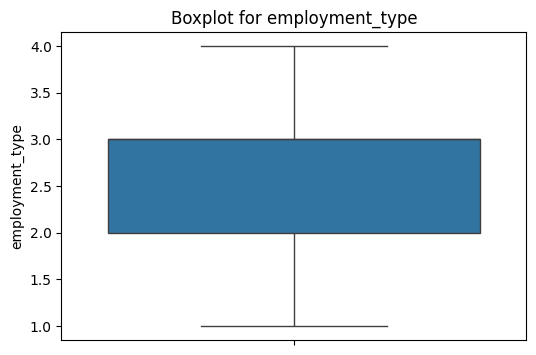

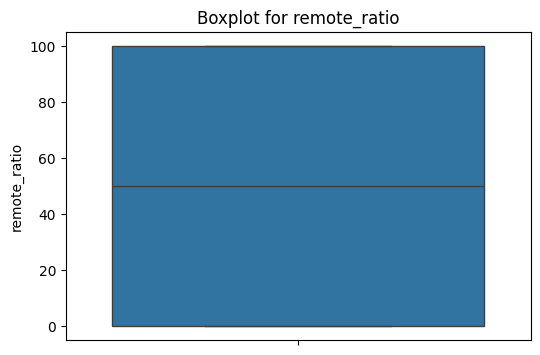

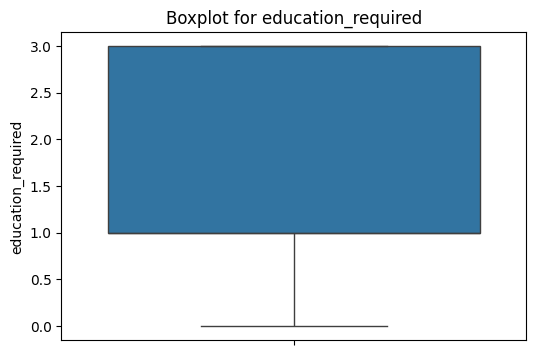

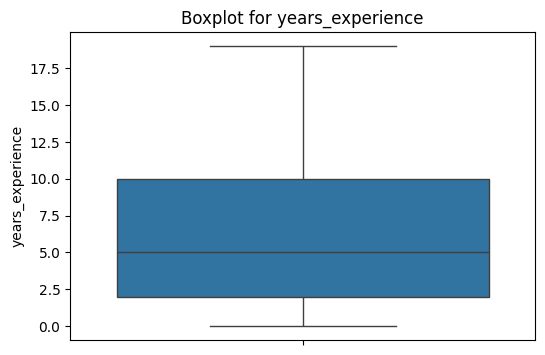

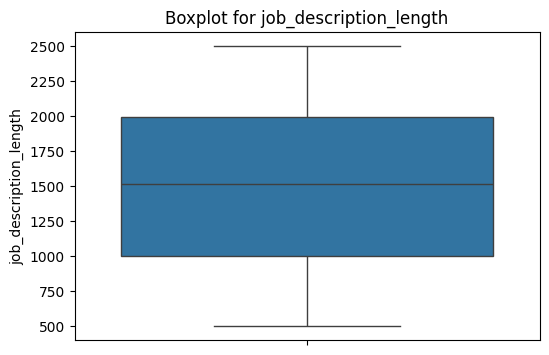

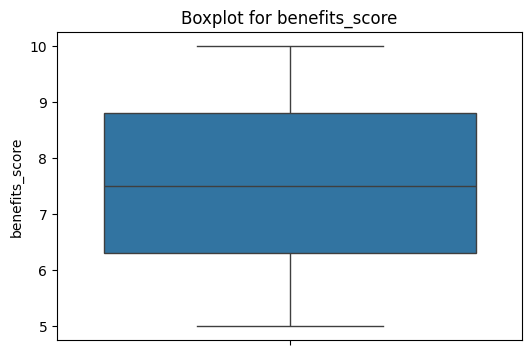

In [31]:
for col in cols:
    plt.figure(figsize=(6,4))
    sns.boxplot(y=ai_dataset[col])
    plt.title(f'Boxplot for {col}')
    plt.show()

In [32]:
q1 = ai_dataset['salary_usd'].quantile(0.25)
q3 = ai_dataset['salary_usd'].quantile(0.75)
iqr = q3 - q1
lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr
ai_outliers = ai_dataset[(ai_dataset['salary_usd'] > lower_bound) & (ai_dataset['salary_usd'] < upper_bound)]

In [33]:
ai_outliers.head(1)

,job_title,salary_usd,experience_level,employment_type,company_location,company_size,remote_ratio,required_skills,education_required,years_experience,posting_date,application_deadline,job_description_length,company_name,industry,benefits_score,salary_display,posting_month,posting_year,application_deadline_month,application_deadline_year,posting_month_name
0,Data Scientist,219728,2,2,Sweden,Medium,0,"Python, Computer Vision, R, Docker",0,13,2024-09-23,2024-10-31,1132,TechCorp Inc,Transportation,6.6,"$219,728",9,2024,10,2024,September


In [34]:
ai_without_outliers = ai_dataset[(ai_dataset['salary_usd'] >= lower_bound) & (ai_dataset['salary_usd'] <= upper_bound)]
ai_without_outliers.head(1)

,job_title,salary_usd,experience_level,employment_type,company_location,company_size,remote_ratio,required_skills,education_required,years_experience,posting_date,application_deadline,job_description_length,company_name,industry,benefits_score,salary_display,posting_month,posting_year,application_deadline_month,application_deadline_year,posting_month_name
0,Data Scientist,219728,2,2,Sweden,Medium,0,"Python, Computer Vision, R, Docker",0,13,2024-09-23,2024-10-31,1132,TechCorp Inc,Transportation,6.6,"$219,728",9,2024,10,2024,September


## KPI 1: Average Salary by Experience Level

In [35]:
ai.head(1)

,job_title,salary_usd,experience_level,employment_type,company_location,company_size,remote_ratio,required_skills,education_required,years_experience,posting_date,application_deadline,job_description_length,company_name,industry,benefits_score
0,Data Scientist,219728,EX,PT,Sweden,M,0,"Python, Computer Vision, R, Docker",Associate,13,23-09-2024,31-10-2024,1132,TechCorp Inc,Transportation,6.6


In [36]:
kpi_salary_by_experience = (
    ai.groupby("experience_level")["salary_usd"]
    .mean()
    .reset_index()
    # .rename(columns={"salary_usd": "avg_salary_usd"})
    .sort_values("salary_usd", ascending=False)
)
print(kpi_salary_by_experience)

  experience_level     salary_usd
1               EX  198485.211033
3               SE  127910.973536
2               MI   91585.485654
0               EN   66773.737130


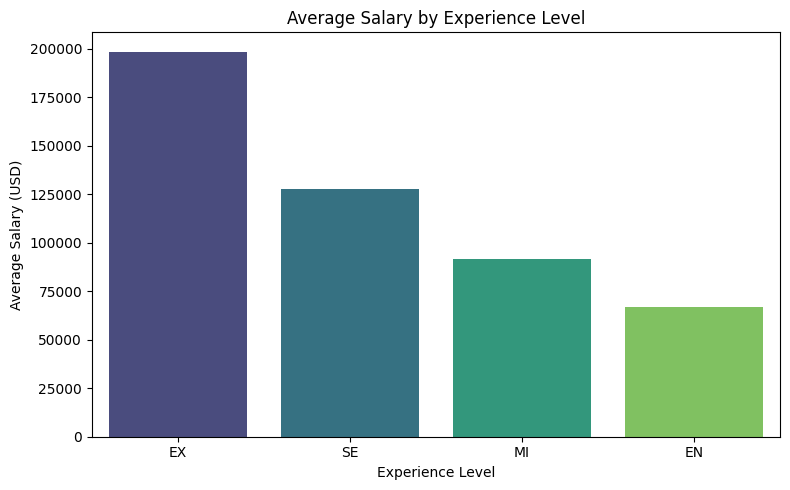

In [37]:
plt.figure(figsize=(8, 5))
sns.barplot(data=kpi_salary_by_experience, x="experience_level", y="salary_usd", palette="viridis")
plt.title("Average Salary by Experience Level")
plt.xlabel("Experience Level")
plt.ylabel("Average Salary (USD)")
plt.tight_layout()
plt.show()

## KPI 2: Remote Work Adoption Rate

In [38]:
total_jobs = len(ai)
remote_friendly_jobs = ai[ai["remote_ratio"] >= 50].shape[0]

remote_adoption_rate = (remote_friendly_jobs / total_jobs) * 100
print(f"Total Jobs: {total_jobs}")
print(f"Remote-Friendly Jobs (≥50% remote): {remote_friendly_jobs}")
print(f"Remote Work Adoption Rate: {remote_adoption_rate:.2f}%")

Total Jobs: 15000
Remote-Friendly Jobs (≥50% remote): 10025
Remote Work Adoption Rate: 66.83%


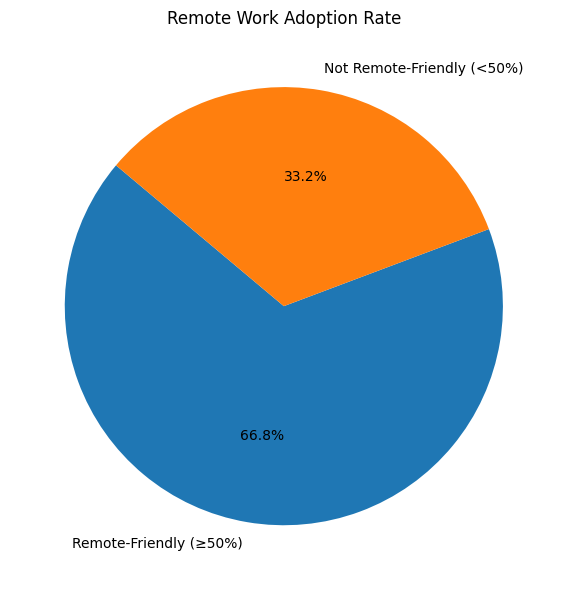

In [39]:
labels = ["Remote-Friendly (≥50%)", "Not Remote-Friendly (<50%)"]
sizes = [remote_friendly_jobs, total_jobs - remote_friendly_jobs]

plt.figure(figsize=(6,6))
plt.pie(sizes, labels=labels, autopct="%1.1f%%", startangle=140)
plt.title("Remote Work Adoption Rate")
plt.tight_layout()
plt.show()

## KPI 3: Job Posting Richness Score

In [40]:
ai['job_description_length'] = pd.to_numeric(ai['job_description_length'], errors='coerce')
overall_richness = ai['job_description_length'].mean()
print(f"🔍 KPI 3 — Job Posting Richness Score (Avg Description Length): {overall_richness:.2f} characters")

🔍 KPI 3 — Job Posting Richness Score (Avg Description Length): 1500.85 characters


In [41]:
richness_by_industry = (
    ai.groupby('industry')['job_description_length']
    .mean()
    .sort_values(ascending=False)
)
print(richness_by_industry.head(10))

industry
Energy            1529.153691
Gaming            1508.686687
Technology        1507.675569
Automotive        1507.462069
Retail            1507.121677
Transportation    1503.672976
Government        1503.068599
Manufacturing     1501.831884
Real Estate       1500.870647
Finance           1498.477407
Name: job_description_length, dtype: float64


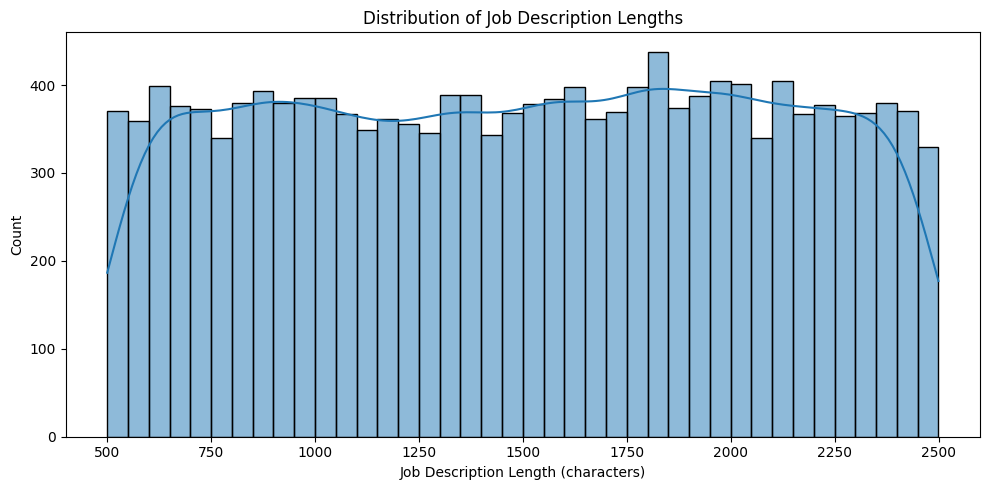

In [42]:
##Visualization #1 — Histogram
plt.figure(figsize=(10,5))
sns.histplot(ai['job_description_length'], bins=40, kde=True)
plt.title("Distribution of Job Description Lengths")
plt.xlabel("Job Description Length (characters)")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

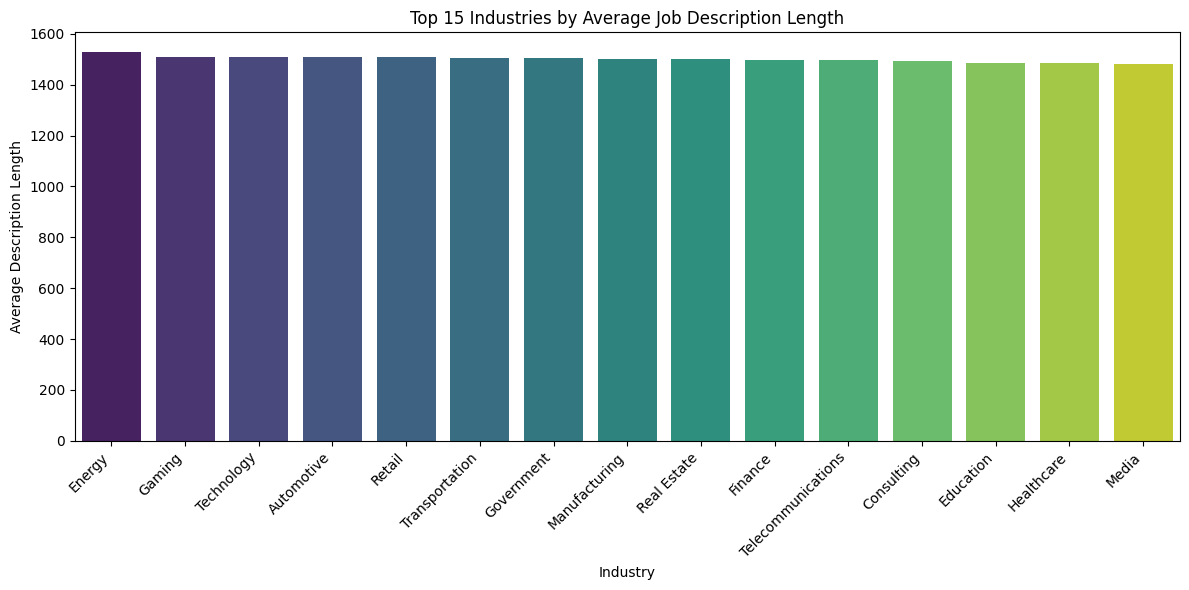

In [43]:
## Visualization #2 — Industry Comparisons
plt.figure(figsize=(12,6))
sns.barplot(
    x=richness_by_industry.index[:15],
    y=richness_by_industry.values[:15],
    palette="viridis"
)

plt.xticks(rotation=45, ha="right")
plt.title("Top 15 Industries by Average Job Description Length")
plt.xlabel("Industry")
plt.ylabel("Average Description Length")
plt.tight_layout()
plt.show()

## KPI 4: salary vs skills regression

In [44]:
def split_skills(s):
    return [x.strip() for x in s.split(",") if x.strip()]

In [45]:
skill_series = ai["required_skills"].apply(split_skills).explode()
skill_counts = skill_series.value_counts()

# Use only skills that appear >= 20 times
MIN_COUNT = 20
selected_skills = skill_counts[skill_counts >= MIN_COUNT].index.tolist()

print(f"Using {len(selected_skills)} skill features.")

# Create binary features
for skill in selected_skills:
    ai[f"skill__{skill}"] = ai["required_skills"].str.contains(skill, case=False).astype(int)


Using 24 skill features.


In [46]:
# regression
feature_cols = [c for c in ai.columns if c.startswith("skill__")]
df = ai.dropna(subset=["salary_usd"])

X = df[feature_cols].astype(float)
y = df["salary_usd"].astype(float)


In [47]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42
)

In [48]:
model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [49]:
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred) ** 0.5  # Manual RMSE
print("\n==== Regression KPI Metrics ====")
print("R²:", round(r2, 4))
print("MAE:", round(mae, 2))
print("RMSE:", round(rmse, 2))


==== Regression KPI Metrics ====
R²: -0.0025
MAE: 50448.82
RMSE: 64321.51


In [50]:
coef = pd.Series(model.coef_, index=feature_cols)
coef_sorted = coef.sort_values(ascending=False)

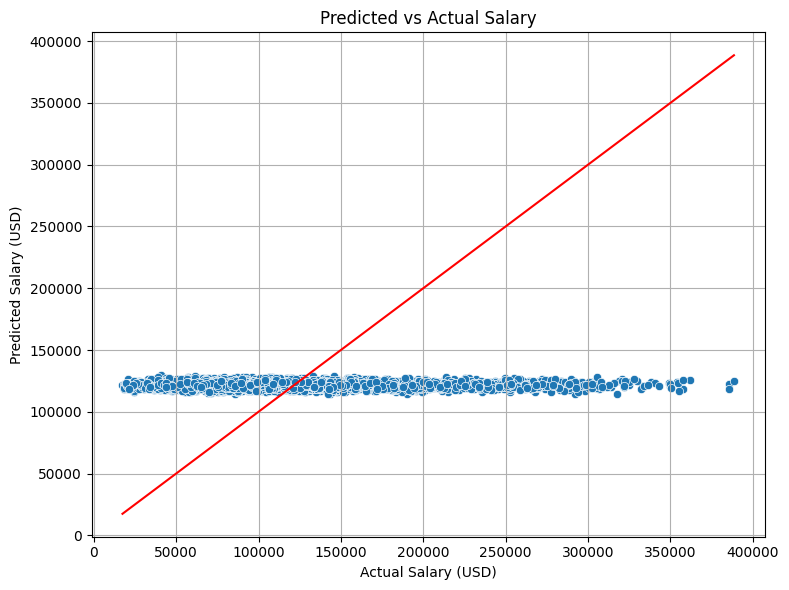

In [51]:
## 1: Predicted vs Actual
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test, y=y_pred)
sns.lineplot(x=y_test, y=y_test, color="red")
plt.title("Predicted vs Actual Salary")
plt.xlabel("Actual Salary (USD)")
plt.ylabel("Predicted Salary (USD)")
plt.grid(True)
plt.tight_layout()
plt.show()

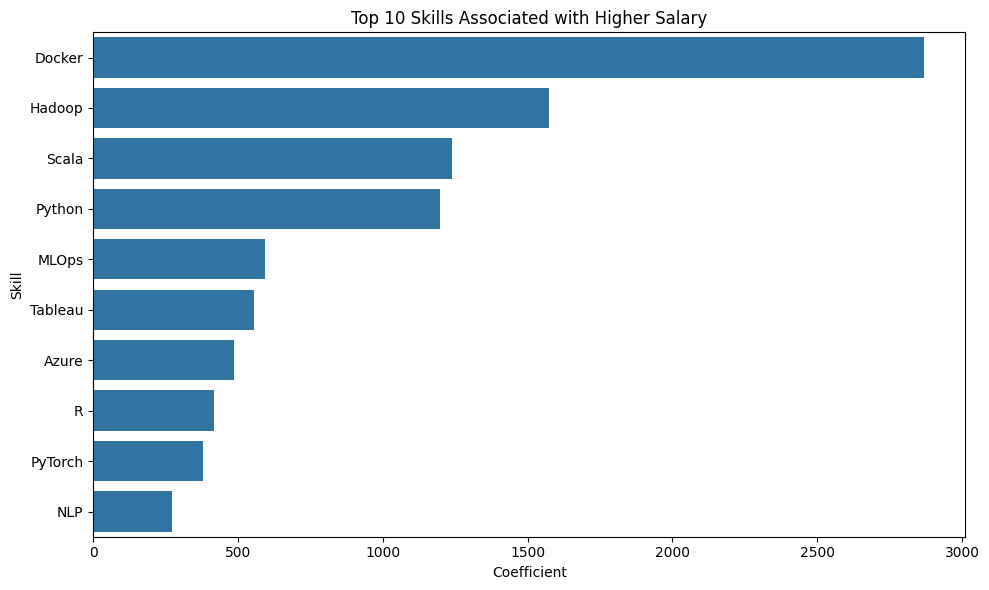

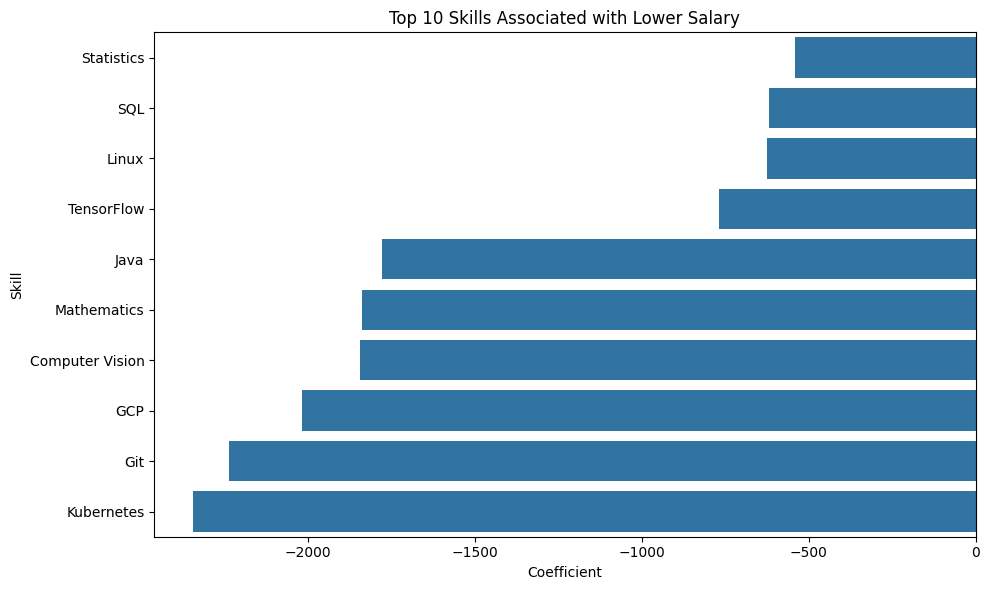

In [52]:
## 2: Top Positive/Negative Skill Coefficients
top_pos = coef_sorted.head(10)
top_neg = coef_sorted.tail(10)

plt.figure(figsize=(10, 6))
sns.barplot(x=top_pos.values, y=[x.replace("skill__", "") for x in top_pos.index])
plt.title("Top 10 Skills Associated with Higher Salary")
plt.xlabel("Coefficient")
plt.ylabel("Skill")
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 6))
sns.barplot(x=top_neg.values, y=[x.replace("skill__", "") for x in top_neg.index])
plt.title("Top 10 Skills Associated with Lower Salary")
plt.xlabel("Coefficient")
plt.ylabel("Skill")
plt.tight_layout()
plt.show()

In [ ]:
# duplicates = df[df.duplicated(keep=False)]
# print("Duplicate rows:")
# print(duplicates)

Duplicate rows:
Empty DataFrame
Columns: [job_title, salary_usd, experience_level, employment_type, company_location, company_size, remote_ratio, required_skills, education_required, years_experience, posting_date, application_deadline, job_description_length, company_name, industry, benefits_score, skill__Python, skill__SQL, skill__TensorFlow, skill__Kubernetes, skill__PyTorch, skill__Scala, skill__Linux, skill__Java, skill__Git, skill__GCP, skill__R, skill__Hadoop, skill__Tableau, skill__Computer Vision, skill__Data Visualization, skill__Spark, skill__MLOps, skill__Azure, skill__AWS, skill__NLP, skill__Deep Learning, skill__Mathematics, skill__Docker, skill__Statistics]
Index: []
